In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/MMM_practice/Orbit_practice/')

Mounted at /content/drive


In [2]:
!pip install --quiet orbit-ml
!pip install --quiet matplotlib==3.1.3

     |████████████████████████████████| 474 kB 33.1 MB/s 
     |████████████████████████████████| 11.2 MB 51.4 MB/s 
     |████████████████████████████████| 722 kB 64.9 MB/s 
     |████████████████████████████████| 67.3 MB 138 kB/s 
     |████████████████████████████████| 957 kB 47.6 MB/s 
     |████████████████████████████████| 13.1 MB 19.7 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
orbit-ml 1.1.2 requires matplotlib>=3.3.2, but you have matplotlib 3.1.3 which is incompatible.


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import orbit
import warnings

from sklearn.preprocessing import MaxAbsScaler
from orbit.models import KTR, ETS
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components

warnings.filterwarnings('ignore')

In [4]:
data = pd.read_excel("Sr Advertising Analyst Work Sample (1).xlsx")

agg_data = data.groupby(["Date", "Ad group alias"])[["Impressions","Spend", "Sales",]].sum()
agg_data = agg_data.drop(["Brand 1 Ad Group 12"], axis=0, level=1) # zero cost train


media_data_raw = agg_data['Impressions'].unstack().fillna(0)
costs_raw = agg_data['Spend'].unstack()
sales_raw = agg_data['Sales'].reset_index().groupby("Date").sum()
media_data_raw["Sales"] = sales_raw

media_data_raw = media_data_raw.reset_index()

In [ ]:
media_data_raw.head()

Ad group alias,Date,Brand 1 Ad Group 1,Brand 1 Ad Group 10,Brand 1 Ad Group 11,Brand 1 Ad Group 13,Brand 1 Ad Group 2,Brand 1 Ad Group 3,Brand 1 Ad Group 4,Brand 1 Ad Group 5,Brand 1 Ad Group 6,...,Brand 1 Ad Group 8,Brand 1 Ad Group 9,Brand 2 Ad Group 1,Brand 2 Ad Group 2,Brand 2 Ad Group 3,Brand 2 Ad Group 4,Brand 2 Ad Group 5,Brand 1 Ad Group 14,Brand 2 Ad Group 6,Sales
0,2021-10-17,3317.0,33.0,50966.0,9519.0,40265.0,0.0,142704.0,55.0,94.0,...,248.0,23321.0,276437.0,424883.0,135366.0,41905.0,9871.0,0.0,0.0,28195.0575
1,2021-10-18,1501.0,30.0,39424.0,14015.0,18545.0,0.0,389663.0,53.0,121.0,...,283.0,28321.0,313907.0,492277.0,119675.0,46550.0,19920.0,50619.0,0.0,25490.7750
2,2021-10-19,771.0,63.0,236572.0,16543.0,13078.0,0.0,810070.0,58.0,122.0,...,245.0,26105.0,296159.0,475287.0,191075.0,0.0,9253.0,43019.0,0.0,34054.9375
3,2021-10-20,958.0,70.0,277649.0,24590.0,10743.0,0.0,821705.0,60.0,111.0,...,234.0,0.0,314952.0,641517.0,98214.0,61017.0,18669.0,45642.0,0.0,30204.4050
4,2021-10-21,1841.0,59.0,251202.0,14236.0,10799.0,0.0,1241204.0,72.0,150.0,...,394.0,0.0,392621.0,412898.0,88922.0,121214.0,12977.0,69165.0,0.0,34461.2050


In [5]:
date_col = "Date"
response_col = "Sales"

regressor_col = ['Brand 1 Ad Group 1', 'Brand 1 Ad Group 10',
       'Brand 1 Ad Group 11', 'Brand 1 Ad Group 13', 'Brand 1 Ad Group 2',
       'Brand 1 Ad Group 3', 'Brand 1 Ad Group 4', 'Brand 1 Ad Group 5',
       'Brand 1 Ad Group 6', 'Brand 1 Ad Group 7', 'Brand 1 Ad Group 8',
       'Brand 1 Ad Group 9', 'Brand 2 Ad Group 1', 'Brand 2 Ad Group 2',
       'Brand 2 Ad Group 3', 'Brand 2 Ad Group 4', 'Brand 2 Ad Group 5',
       'Brand 1 Ad Group 14', 'Brand 2 Ad Group 6']
split_point = -28 # 28 days to end of data

media_data_train = media_data_raw.iloc[:split_point].copy()
media_data_test = media_data_raw.iloc[split_point:].copy()

scaler = MaxAbsScaler() # better than standard
media_data_train.loc[:, regressor_col] = scaler.fit_transform(media_data_train.loc[:, regressor_col])
media_data_test.loc[:, regressor_col] = scaler.transform(media_data_test.loc[:, regressor_col])

scaler_y = MaxAbsScaler()
media_data_train.loc[:, response_col] = scaler_y.fit_transform(media_data_train.loc[:, response_col].values.reshape(-1,1))

media_names = media_data_raw.columns

In [6]:
media_data_train.head()

Ad group alias,Date,Brand 1 Ad Group 1,Brand 1 Ad Group 10,Brand 1 Ad Group 11,Brand 1 Ad Group 13,Brand 1 Ad Group 2,Brand 1 Ad Group 3,Brand 1 Ad Group 4,Brand 1 Ad Group 5,Brand 1 Ad Group 6,...,Brand 1 Ad Group 8,Brand 1 Ad Group 9,Brand 2 Ad Group 1,Brand 2 Ad Group 2,Brand 2 Ad Group 3,Brand 2 Ad Group 4,Brand 2 Ad Group 5,Brand 1 Ad Group 14,Brand 2 Ad Group 6,Sales
0,2021-10-17,0.416656,0.244444,0.169593,0.243117,0.713109,0.0,0.089578,0.157143,0.024556,...,0.232210,0.559888,0.444752,0.489409,0.708444,0.287243,0.098947,0.000000,0.0,0.686744
1,2021-10-18,0.188544,0.222222,0.131186,0.357946,0.328439,0.0,0.244599,0.151429,0.031609,...,0.264981,0.679927,0.505037,0.567038,0.626325,0.319083,0.199679,0.731859,0.0,0.620876
2,2021-10-19,0.096847,0.466667,0.787209,0.422511,0.231617,0.0,0.508496,0.165714,0.031870,...,0.229401,0.626726,0.476482,0.547468,1.000000,0.000000,0.092753,0.621976,0.0,0.829473
3,2021-10-20,0.120337,0.518519,0.923895,0.628033,0.190263,0.0,0.515799,0.171429,0.028997,...,0.219101,0.000000,0.506718,0.738943,0.514008,0.418248,0.187139,0.659900,0.0,0.735685
4,2021-10-21,0.231252,0.437037,0.835891,0.363590,0.191255,0.0,0.779127,0.205714,0.039185,...,0.368914,0.000000,0.631677,0.475604,0.465377,0.830876,0.130082,1.000000,0.0,0.839368


In [7]:
%%time

ktr_ = KTR(
    response_col=response_col,
    date_col=date_col,
    regressor_col=regressor_col,
    seed=2021,
    seasonality=[7], # cant use 365 seasonality because have only 59 rows
    estimator='pyro-svi',
    n_bootstrap_draws=1e4,
    num_steps=301,
    message=100)

ktr_.fit(media_data_train)

CPU times: user 4.91 s, sys: 371 ms, total: 5.28 s
Wall time: 59.3 s


In [8]:
predicted_df = ktr_.predict(df=media_data_test)

In [9]:
predicted_df.head()

,Date,prediction_5,prediction,prediction_95
0,2021-12-15,0.356788,0.679260,0.979077
1,2021-12-16,0.502209,0.837049,1.172663
2,2021-12-17,0.497134,0.846548,1.173849
3,2021-12-18,0.503617,0.851300,1.187771
4,2021-12-19,0.344288,0.748662,1.117616


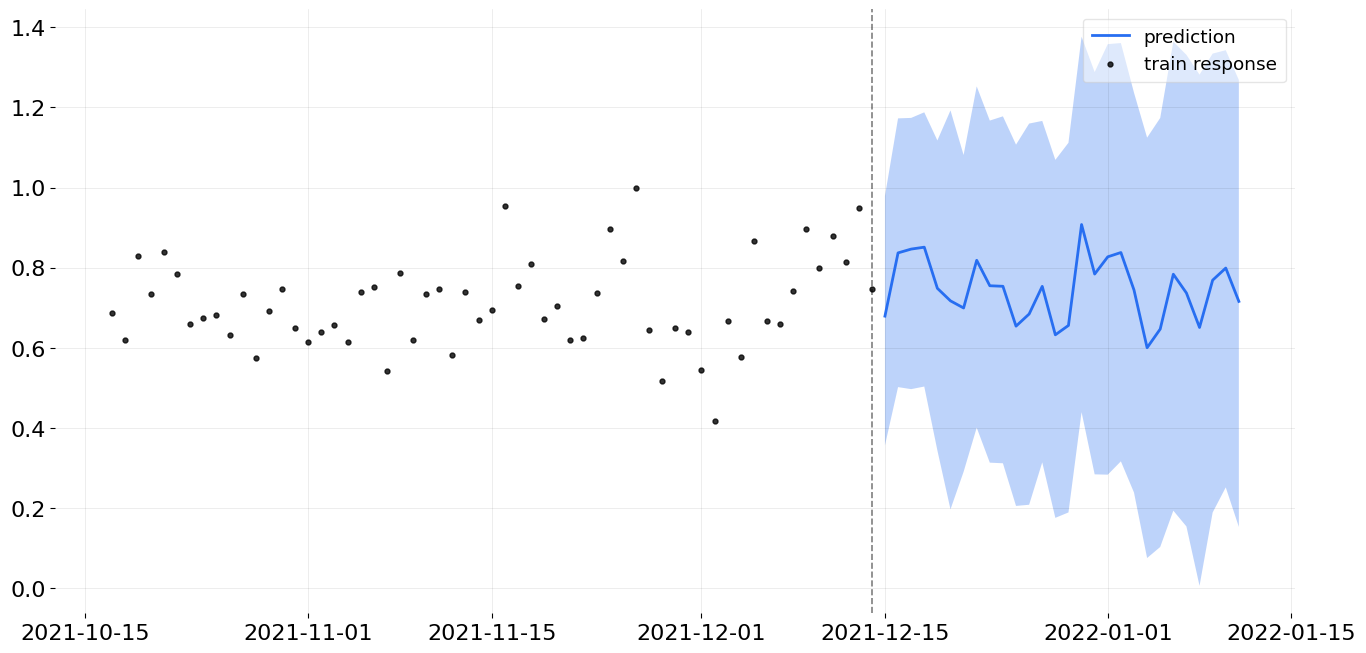

In [11]:
_ = plot_predicted_data(media_data_train, predicted_df, date_col, response_col)

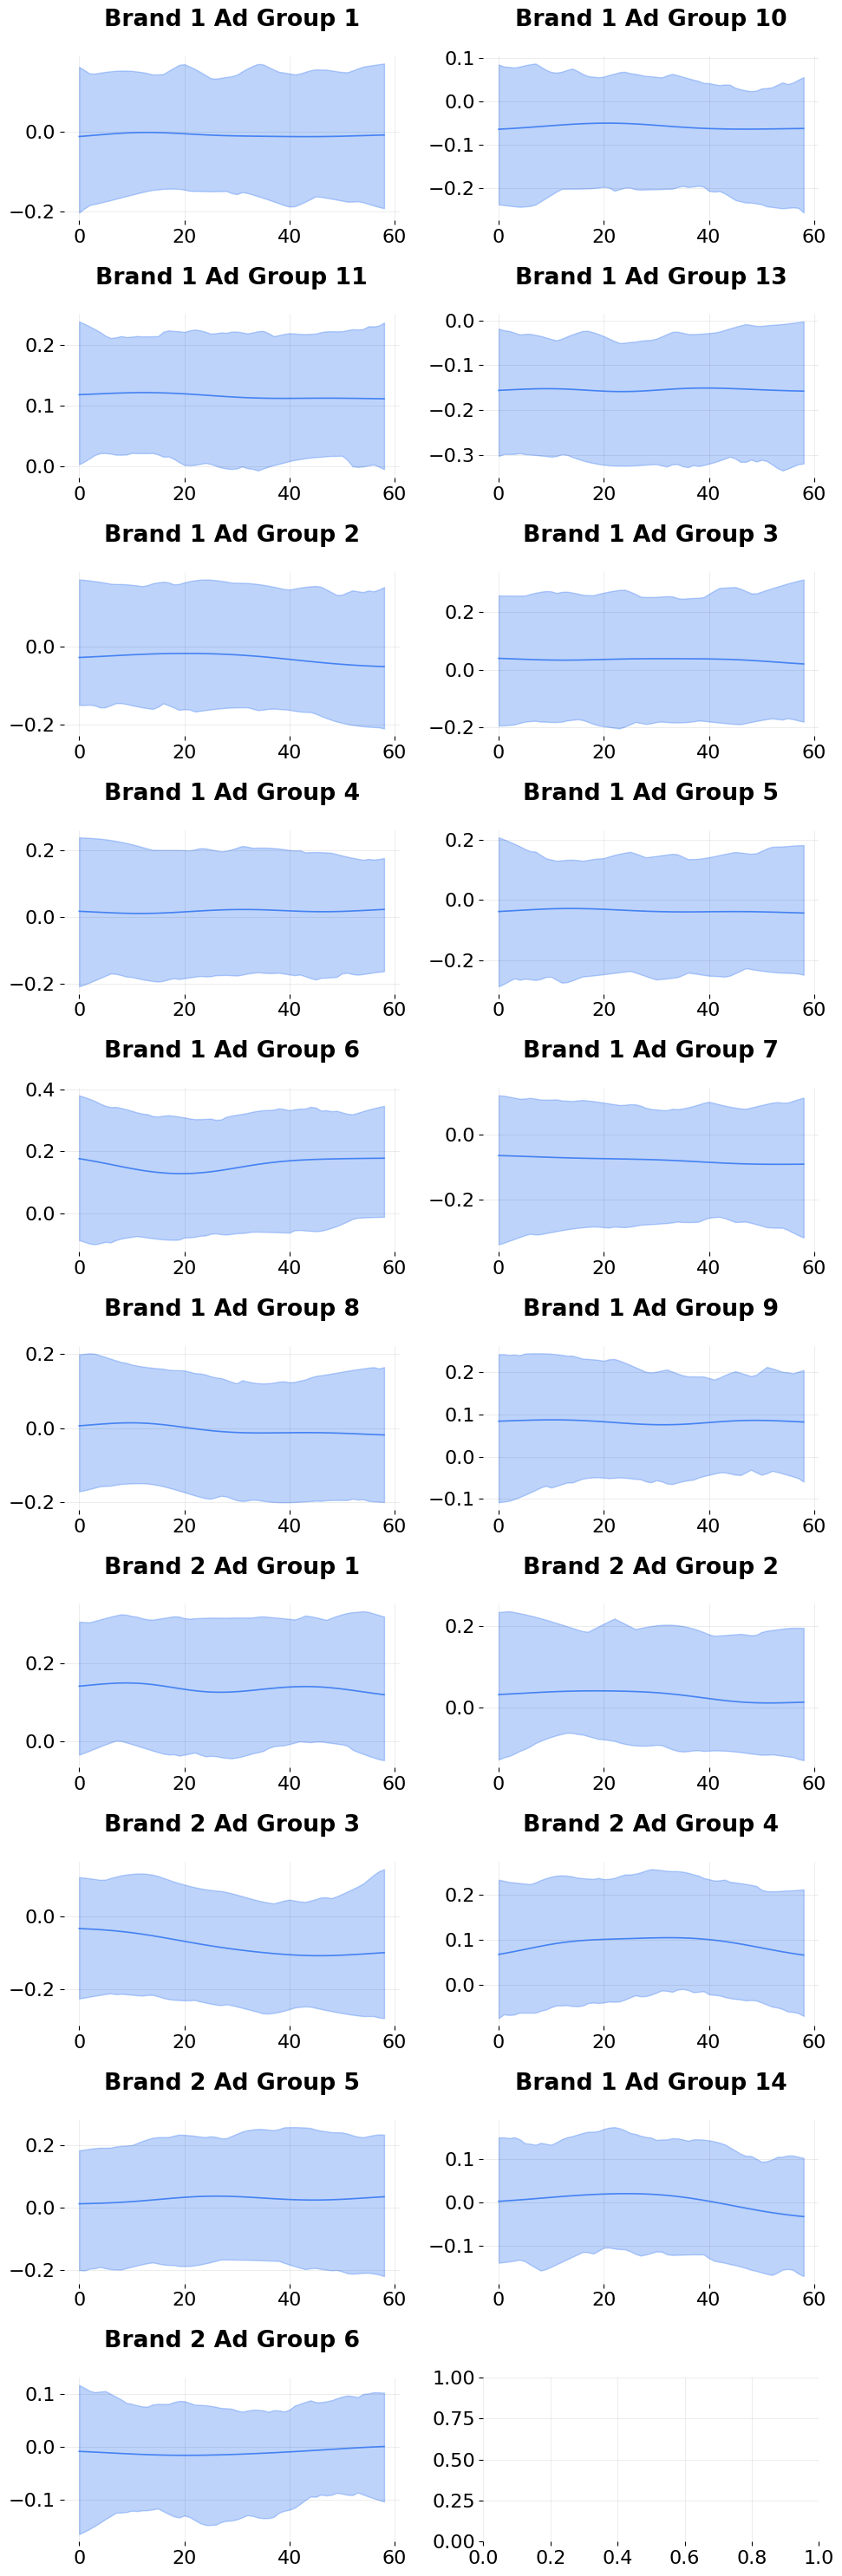

In [13]:
ktr_.plot_regression_coefs(figsize=(10, 30), include_ci=True)
plt.show()

In [14]:
media_data_full = pd.concat([media_data_train, media_data_test], axis=0, ignore_index=True)

In [15]:
contribution = scaler_y.inverse_transform(ktr_.get_regression_coefs().iloc[:, 1:] * media_data_full[regressor_col])
contribution = pd.DataFrame(contribution,columns=regressor_col).sum(axis=0)

In [16]:
contribution.head()

Brand 1 Ad Group 1      -9124.133278
Brand 1 Ad Group 10    -29323.881010
Brand 1 Ad Group 11     67477.185456
Brand 1 Ad Group 13   -187265.051660
Brand 1 Ad Group 2     -31350.162324
dtype: float64

In [17]:
roi = (contribution.sum(axis=0) / costs_raw.sum(axis=0)).clip(0)

In [18]:
df_regression_coefs = ktr_.get_regression_coefs()

In [19]:
df_regression_coefs.head()

,Date,Brand 1 Ad Group 1,Brand 1 Ad Group 10,Brand 1 Ad Group 11,Brand 1 Ad Group 13,Brand 1 Ad Group 2,Brand 1 Ad Group 3,Brand 1 Ad Group 4,Brand 1 Ad Group 5,Brand 1 Ad Group 6,Brand 1 Ad Group 7,Brand 1 Ad Group 8,Brand 1 Ad Group 9,Brand 2 Ad Group 1,Brand 2 Ad Group 2,Brand 2 Ad Group 3,Brand 2 Ad Group 4,Brand 2 Ad Group 5,Brand 1 Ad Group 14,Brand 2 Ad Group 6
0,2021-10-17,-0.012251,-0.064657,0.117892,-0.156062,-0.027465,0.040265,0.017312,-0.038020,0.176897,-0.065174,0.006778,0.084116,0.142100,0.032202,-0.034011,0.067723,0.013438,0.003024,-0.008327
1,2021-10-18,-0.011219,-0.064005,0.118247,-0.155484,-0.026872,0.039600,0.016569,-0.037095,0.174210,-0.065635,0.007901,0.084528,0.143392,0.032812,-0.034611,0.069763,0.013755,0.003751,-0.008751
2,2021-10-19,-0.010149,-0.063300,0.118615,-0.154906,-0.026238,0.038914,0.015804,-0.036131,0.171334,-0.066129,0.009039,0.084949,0.144684,0.033457,-0.035305,0.071926,0.014133,0.004534,-0.009204
3,2021-10-20,-0.009058,-0.062544,0.118991,-0.154341,-0.025570,0.038217,0.015031,-0.035140,0.168288,-0.066651,0.010166,0.085369,0.145943,0.034132,-0.036103,0.074189,0.014581,0.005371,-0.009681
4,2021-10-21,-0.007967,-0.061743,0.119368,-0.153808,-0.024873,0.037523,0.014266,-0.034139,0.165097,-0.067198,0.011251,0.085779,0.147128,0.034827,-0.037016,0.076528,0.015107,0.006256,-0.010178


In [22]:
%%time
ets = ETS(
    response_col=response_col,
    date_col=date_col,
    estimator='stan-mcmc',
    seasonality=52,
    seed=8888,
    num_warmup=400,
    num_sample=400,
)
ets.fit(df=media_data_train)
predicted_df = ets.predict(df=media_data_test)

CPU times: user 1.85 s, sys: 167 ms, total: 2.02 s
Wall time: 56.2 s


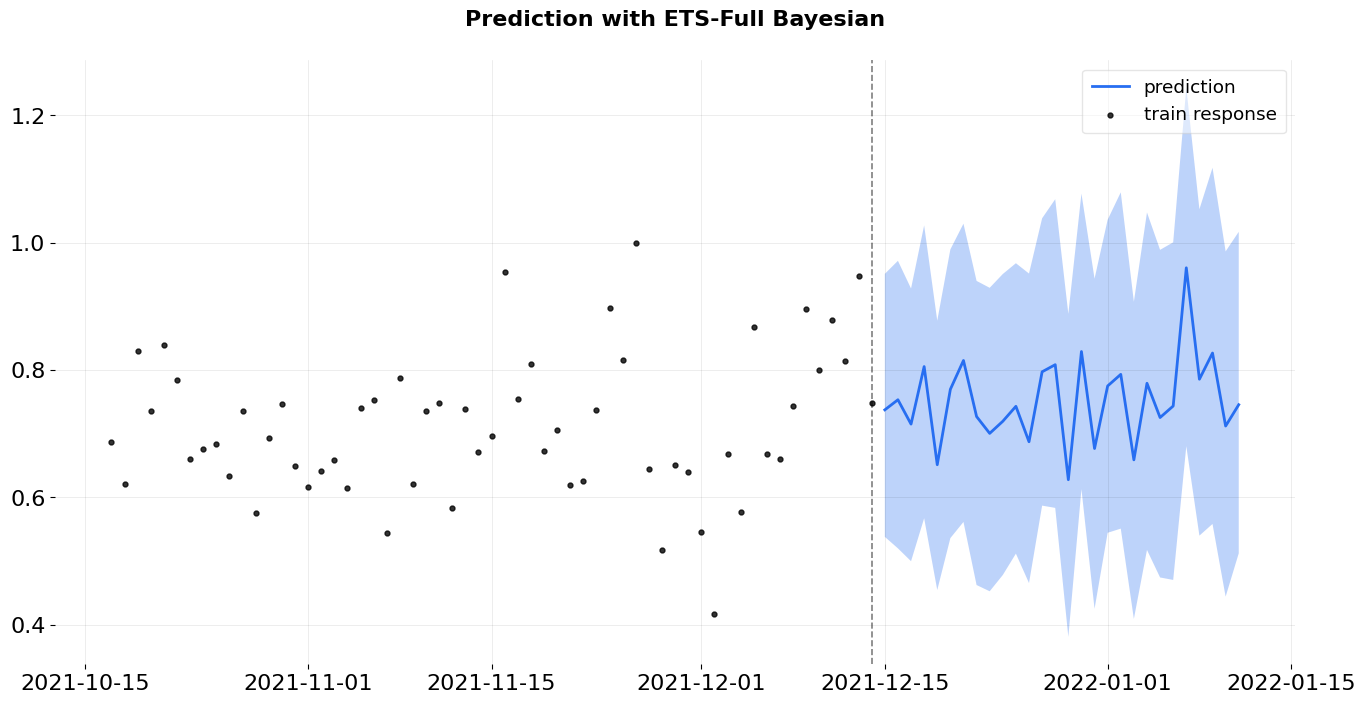

In [23]:
_ = plot_predicted_data(media_data_train, predicted_df, date_col, response_col, title='Prediction with ETS-Full Bayesian')

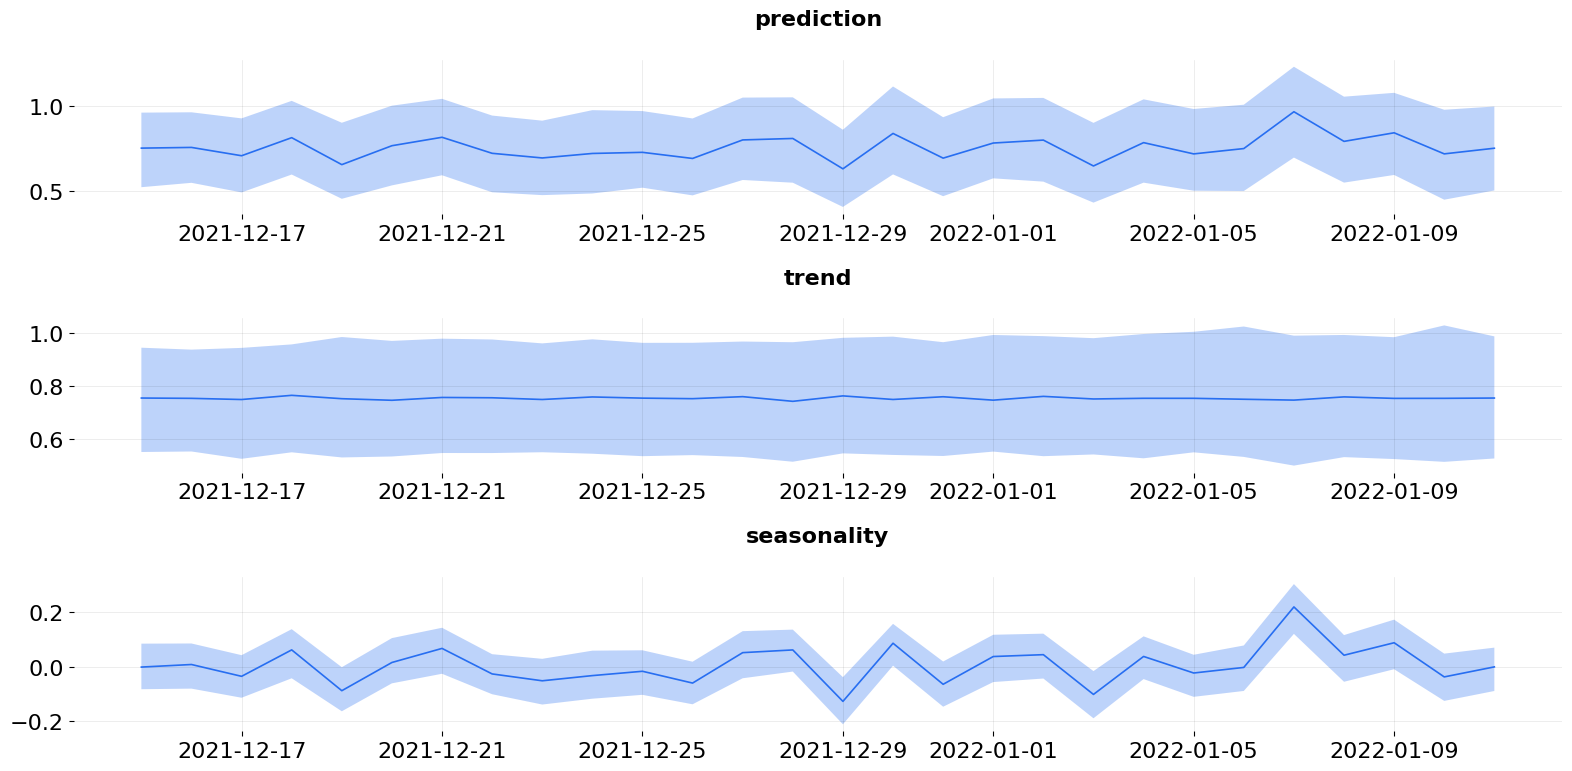

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff45a955710>,
      dtype=object)

In [27]:
# predicted_df = ets.predict(df=df, decompose=True)
predicted_df = ets.predict(df=media_data_test, decompose=True)
plot_predicted_components(predicted_df, date_col=date_col,
                          plot_components=['prediction', 'trend', 'seasonality'])